# Ejercicio 2

Extender el autoencoder para que opere como un Autoencoder Variacional.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits

import sys; sys.path.append("..")
from src.utils import read_data

In [2]:
from sklearn import datasets    # Solo lo usamos para obtener los datos
digits = datasets.load_digits()

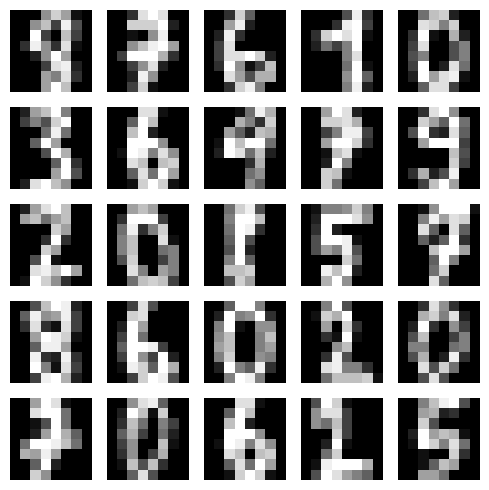

In [209]:
indices = [i for i, y in enumerate(digits.target) if y in [1,2,3,4,5,6,7,8,9,0]] # TODO probar diferentes combinaciones
fig, ax = plt.subplots(5, 5, figsize=(5, 5))

for i in range(5):
    for j in range(5):
        ind = np.random.choice(indices)

        ax[i, j].imshow(digits.data[ind].reshape(8, 8), cmap="gray")
        #ax[i, j].set_title(digits.target[ind])
        ax[i, j].axis("off")

plt.tight_layout()
plt.show()

In [81]:
from src.optimizer import Adam
from src.autoencoder import Autoencoder
from src.perceptron_multicapa import StochasticLayer, Layer

vae = Autoencoder([
    Layer(64, 32, "sigmoid"),
    Layer(32, 16, "sigmoid"),
    StochasticLayer(16, 2),
    Layer( 2, 16, "sigmoid"),
    Layer(16, 32, "sigmoid"),
    Layer(32, 64, "sigmoid"),
], bottleneck_index=2, loss_fun="mse")

vae.optimizer.learning_rate = 0.01
history = vae.train_autoencoder(digits.data / 16, epochs=10, batch_size=10)

In [93]:
history = vae.train_autoencoder(digits.data / 16, epochs=100, batch_size=10)

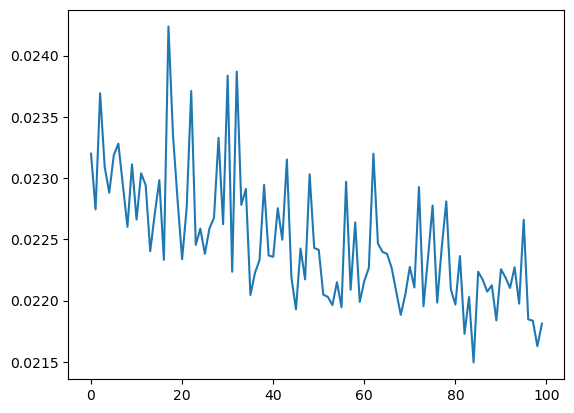

In [94]:
e = [h["epoch"] for h in history]
l = [h["train_loss"] for h in history]
plt.plot(e, l)
plt.show()

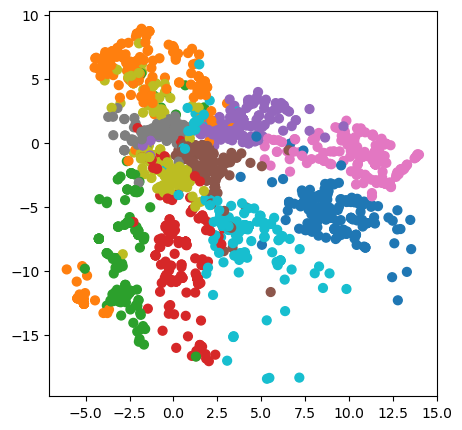

In [194]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
Z = np.array([vae.encode(x) for x in digits.data])
scatter = plt.scatter(Z[:, 0], Z[:, 1], c=digits.target, cmap='tab10', s=40)
plt.show()

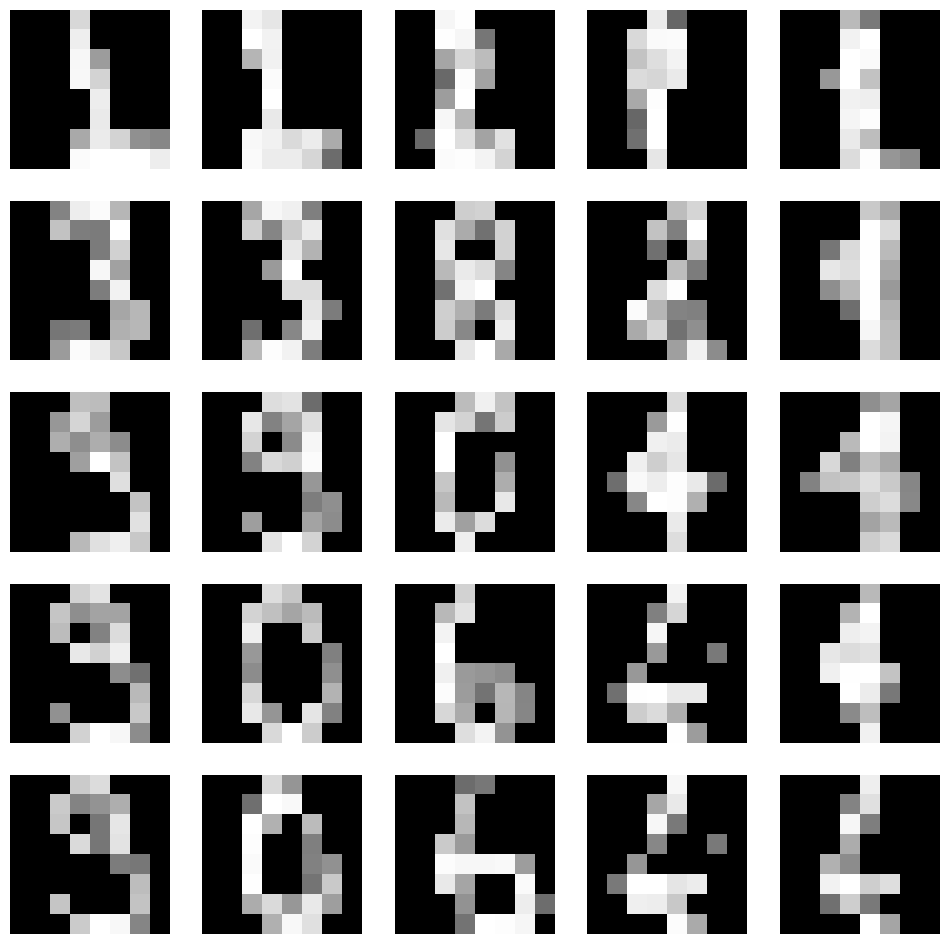

In [206]:
cantidad = 5

x = np.linspace(-5, 15, cantidad)
y = np.linspace(-15, 10, cantidad)

threshold = 0.4

fig, ax = plt.subplots(len(x), len(y), figsize=(12,12))
for i, xi in enumerate(x):
	for j, yj in enumerate(y):
		
		numero = vae.decode([xi, yj])
		numero = np.where(numero > threshold, numero, 0)
		
		ax[i, j].imshow(numero.reshape(8, 8), cmap='gray', interpolation='nearest')
		ax[i, j].set_axis_off()


plt.show()